# Hierarchical SHAP

This notebook contains code and examples for a hierarchical implementation of Shapley coefficients evaluation for images, with a fixed size of features per layer.



In [13]:
#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#INSTALL SHAP
!pip install shap
import shap

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



## Load the model

This pre-trained model detects the presence of a cross in the image. If the cross is detected, the image is labeled with a ```1```, with a ```0``` otherwhise.

In [14]:
#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
background = torch.mean(X, dim = 0)
background.detach()
print(background.shape)

# LOAD EXAMPLE IMAGES
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
example_batch_size = 2
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)

# LABEL = 0
image0 = images[0]
label0 = labels[0]
input0 = image0.view(-1, 3, 100, 120)
output0 = model(input0)
print(output0)

# LABEL = 1
image1 = images[1]
label1 = labels[1]
input1 = image1.view(-1, 3, 100, 120)
output1 = model(input1)
print(output1)

torch.Size([3, 100, 120])
tensor([[ 11.1314, -13.0076]], grad_fn=<AddmmBackward>)
tensor([[-79.0918,  88.0700]], grad_fn=<AddmmBackward>)


In [25]:
# GLOBAL STAT VARIABLES
computed = 0
rejected = 0

class HierarchicalSHAPNode:

  def __init__(self, depth, M, features, masks, path = None, score = None):
    self.depth = depth
    self.M = M
    self.features = features
    self.masks = masks
    self.path = path
    self.score = score

  def computeShap(self, feature, predictions):
    feature_index = np.where(feature == 1)
    subset_indices = np.where(self.masks[:, feature_index[0][0]] == 0)
    subset = self.masks[subset_indices]
    added_subset = [np.add(sub, feature) for sub in subset] 
    deltas = np.array(list(zip(added_subset, subset)))
    diffs = [1/comb(self.M - 1, np.sum(b)) * (predictions[self.mask2str(a)] - predictions[self.mask2str(b)]) for a, b in deltas]
    phi = np.sum(diffs) / self.M
    return phi.detach().numpy()

  def mask2path(self, mask):
    if self.path is None:
      return [mask]
    else:
      return np.concatenate((self.path, mask))
  
  def mask2str(self, mask):
    return reduce(lambda a, b: str(a) + str(b), mask.astype(int)) 

  def str2mask(self, string):
    L = len(string) 
    mask = np.empty((L,))
    for i in range(L):
      mask[i] = int(string[i])
    return mask
  
  def pathMaskCoordinates(self, path, startRow = 0, endRow = 100, startColumn = 0, endColumn = 120):
    if path is not None:
      for layer in path:
        w = endColumn - startColumn
        h = endRow - startRow
        feature_index = np.where(layer == 1)[0]
        if feature_index == 0:
          endRow = startRow + h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 1:
          endRow = startRow + h / 2
          startColumn += w / 2
        elif feature_index == 2:
          startRow += h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 3:
          startRow += h / 2
          startColumn += w / 2
    return int(startRow), int(endRow), int(startColumn), int(endColumn)
  
  def maskInput(self, mask, rootInput, startRow, endRow, startColumn, endColumn, background):
    w = endColumn - startColumn
    h = endRow - startRow
    maskedInput = rootInput.clone();
    maskIndices = np.where(mask == 0)[0]
    for index in maskIndices:
      maskStartRow = startRow
      maskEndRow = endRow
      maskStartColumn = startColumn
      maskEndColumn = endColumn
      if index == 0:
        maskEndRow = startRow + h / 2
        maskEndColumn = startColumn + w / 2
      elif index == 1:
        maskEndRow = startRow + h / 2
        maskStartColumn += w / 2
      elif index == 2:
        maskStartRow += h / 2
        maskEndColumn = startColumn + w / 2
      elif index == 3:
        maskStartRow += h / 2
        maskStartColumn += w / 2
      maskStartRow = int(maskStartRow)
      maskEndRow = int(maskEndRow)
      maskStartColumn = int(maskStartColumn)
      maskEndColumn = int(maskEndColumn)
      maskedInput[:, maskStartRow:maskEndRow+1, maskStartColumn:maskEndColumn+1] = background[:, maskStartRow:maskEndRow+1, maskStartColumn:maskEndColumn+1]
    maskedInput = maskedInput.view(-1, 3, 100, 120)
    return maskedInput

  def rootPathInput(self, path, input, background, w = 120, h = 100):
    startRow, endRow, startColumn, endColumn = self.pathMaskCoordinates(path, 0, h, 0, w)
    rootInput = background.clone()
    rootInput[:, startRow:endRow+1, startColumn:endColumn+1] = input[:, startRow:endRow+1, startColumn:endColumn+1]
    return rootInput, startRow, endRow, startColumn, endColumn
  
  def nodeScores(self, model, input, background, label, threshold, minW, minH):
    # 
    rootInput, startRow, endRow, startColumn, endColumn = self.rootPathInput(self.path, input, background)
    rootw = endColumn - startColumn
    rooth = endRow - startRow
    # Stop when it reaches the deepest layer and return current node
    if (rootw < minW) or (rooth < minH):
      return self
    # If not, go down another level and compute shap coefficients for features
    predictions = {self.mask2str(mask): model(self.maskInput(mask, rootInput, startRow, endRow, startColumn, endColumn, background))[:, label] for mask in self.masks}
    phis = {self.mask2str(feature): self.computeShap(feature, predictions) for feature in self.features}

    # Update number of computed features
    global computed
    computed += self.M

    # Convert SHAP dictionary to lists -> TODO: evaluate wether SHAP dictionary is necessary
    values = np.fromiter(phis.values(), dtype=float)
    keys = list(phis.keys())

    # Identify relevant features
    relevantIndices = np.where(values > threshold)[0]

    # Update number of rejected features
    global rejected
    rejected += self.M - len(relevantIndices)

    # Initialize children and recursively compute SHAP values
    children = []
    for relevantIndex in relevantIndices:
      childPath = np.array([self.str2mask(keys[relevantIndex])])
      if self.path is not None:
        childPath = np.concatenate((self.path, childPath))
      child = HierarchicalSHAPNode(self.depth + 1, self.M, self.features, self.masks, path = childPath, score = values[relevantIndex])
      children.append(child.nodeScores(model, input, background, label, threshold, minW, minH))
    return children

class HierarchicalSHAPExplainer:

  def __init__(self, model, background, M):
    self.M = M
    self.MEAN = np.array([0.5, 0.5, 0.5])
    self.STD = np.array([0.5, 0.5, 0.5])
    self.input = input
    self.background = background
    self.masks = self.generateMasks() 
    self.features = np.identity(self.M, dtype=np.bool).reshape((self.M, self.M))

  def generateMasks(self):
    masks = np.ones((1,self.M), dtype=np.bool) # initialize masks array with all features on -> no need to compute permutations fro |S| = M
    for i in range(self.M):
      s = np.zeros(self.M, dtype=np.bool)
      s[0:i] = 1
      p = permutations(s)
      a = np.array(list(set(p)))
      masks = np.concatenate((masks, a))
    return masks

  def flatten(self, l):
    for el in l:
      if isinstance(el, list) and not isinstance(el, (str, bytes)):
        yield from flatten(el)
      else:
        yield el

  def addNodeMask(node, map):
    startRow, endRow, startColumn, endColumn = node.pathMaskCoordinates(node.path)
    map[startRow:endRow+1, startColumn:endColumn+1] = node.score

  def explain(self, input, background, label = None, threshold = 0, minW = 2, minH = 2):
    global computed
    computed = 0
    global rejected 
    rejected = 0
    mainNode = HierarchicalSHAPNode(0, 4, self.features, self.masks, score = 1)
    nodes = mainNode.nodeScores(model, input, background, label, threshold, minW, minH)

    flatnodes = list(flatten(nodes))
    saliency_map = np.zeros((100, 120))
    for node in flatnodes:
      addNodeMask(node, saliency_map)

    fix, (ax1, ax2) = plt.subplots(1, 2)
    im = Utils.input2image(input, MEAN, STD)
    ax1.imshow(im)
    ax1.set_title("Input image")
    ax2.imshow(saliency_map)
    ax2.set_title("Saliency map")
    return saliency_map

# Initialize explainer
explainer = HierarchicalSHAPExplainer(model, background, 4)

STARTED EXPLAINING IMAGE 1 @ 1596658724.6874287 s
Computed 1752 features out of 12000 pixels ( 14.6 %) in 15653.261 ms -> 8.935 ms per feature
Rejected 586 features ( 33.45 %) @ threshold = 0


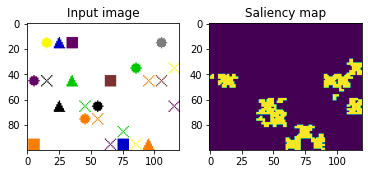

In [26]:
# EXPLAIN IMAGE 1
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 2
minH = 2
saliency_map = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = H)
tf = time.time()
print("Computed", computed ,"features out of", 100*120, "pixels (", round(computed/120, 2), "%) in", round((tf -t0) * 1000, 3), "ms ->", round(((tf-t0)*1000)/computed, 3), "ms per feature")
print("Rejected", rejected, "features (", round(rejected/computed*100, 2), "%) @ threshold =", threshold)

STARTED EXPLAINING IMAGE 0 @ 1596658942.8207324 s
Computed 996 features out of 12000 pixels ( 8.3 %) in 9025.578 ms -> 9.062 ms per feature
Rejected 588 features ( 59.04 %) @ threshold = 0


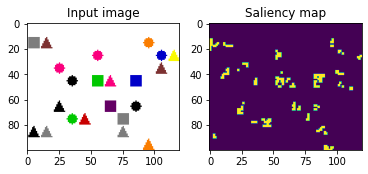

In [27]:
# EXPLAIN IMAGE 0
t0 = time.time()
print("STARTED EXPLAINING IMAGE 0 @", t0, "s")
saliency_map = explainer.explain(image0, background, label = 0)
tf = time.time()
print("Computed", computed ,"features out of", 100*120, "pixels (", round(computed/120, 2), "%) in", round((tf -t0) * 1000, 3), "ms ->", round(((tf-t0)*1000)/computed, 3), "ms per feature")
print("Rejected", rejected, "features (", round(rejected/computed*100, 2), "%) @ threshold =", threshold)